# Exploring Popular Image Augmentation Libraries with the JATIC-Toolbox

This is a simple notebook exploring the current state of popular image augmentation libraries. Additionally, the usability of the Augmentation protocol from the JATIC Toolbox will be considered.

## Table Of Contents

* [Environment Setup](#environment-setup)
* [Initial Image and Detections](#init-image-and-detections)
* [Albumentations](#albumentations)
  * [ReplayCompose](#replaycompose)
* [AugLy](#augly)
* [imgaug](#imgaug)
* [Kornia](#kornia)
* [Torchvision Transforms](#torchvision-transforms)
* [NVIDIA DALI](#dali)

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys

!{sys.executable} -m pip install -qU pip
print("Installing augly...")
!{sys.executable} -m pip install -q augly[image]
print("Installing albumentations...")
!{sys.executable} -m pip install -q albumentations
print("Installing imgaug...")
!{sys.executable} -m pip install -q imgaug
print("Installing kornia...")
!{sys.executable} -m pip install -q kornia
print("Installing dali...")
!{sys.executable} -m pip install -q --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda120
print("Installing torch and torchvision...")
!{sys.executable} -m pip install -q "torch!=2.0.1" "torchvision==0.16"
print("Installing smqtk-detection...")
!{sys.executable} -m pip install -qU smqtk-detection[centernet]
# Remove opencv-python, which requires libGL, which we don't require here, and replace with opencv-python-headless
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing augly...
Installing albumentations...
Installing imgaug...
Installing kornia...
Installing dali...
Installing torch and torchvision...
Installing smqtk-detection...
Installing headless OpenCV...
Done!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
from matplotlib import pyplot as plt  # type: ignore
from matplotlib.patches import Rectangle  # type: ignore
from matplotlib.axes import Axes  # type: ignore

import numpy as np
import os
import random
import torch  # type: ignore
import urllib.request
from PIL import Image
from typing import (
    TYPE_CHECKING, Dict, Hashable, Iterable, Optional, Tuple, TypedDict, Sequence
)

import jatic_toolbox.protocols as pr

from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone
from smqtk_image_io.bbox import AxisAlignedBoundingBox

import albumentations as A  # type: ignore

import augly.image as imaugs  # type: ignore
from augly.image import aug_np_wrapper  # type: ignore

import imgaug as ia  # type: ignore
import imgaug.random  # type: ignore
import imgaug.augmenters as iaa  # type: ignore
from imgaug.augmentables.bbs import BoundingBoxesOnImage  # type: ignore

import kornia as K  # type: ignore
from kornia.augmentation import AugmentationSequential  # type: ignore
from kornia.geometry.bbox import bbox_generator  # type: ignore

from torchvision import tv_tensors  # type: ignore
from torchvision.transforms import v2 as T   # type: ignore

from nvidia.dali import pipeline_def  # type: ignore 
import nvidia.dali.fn as fn  # type: ignore 
from nvidia.dali.fn import flip as fnflip   # type: ignore
from nvidia.dali.fn import bb_flip as fnbb_flip   # type: ignore
from nvidia.dali.fn import brightness_contrast as fnbrightness_contrast  # type: ignore
import nvidia.dali.fn.random as fnrand  # type: ignore 

## Initial Image and Detections <a name="init-image-and-detections"></a>

We'll perform augmentations on a singular image from Visdrone and its detections from the SMQTK-implementation of the CenterNet model.

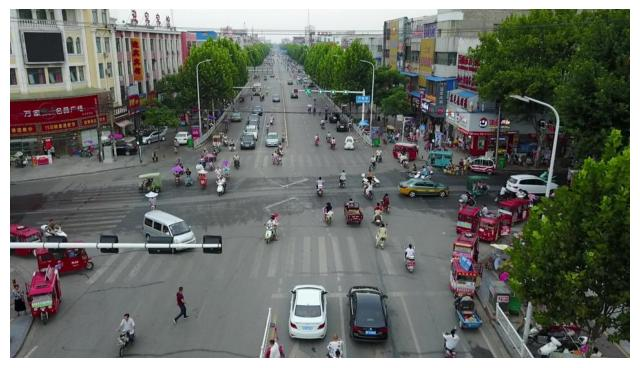

In [3]:
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

url = 'https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download'

img_path = os.path.join(data_dir, 'visdrone_img.jpg')
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)
    
img = np.asarray(Image.open(img_path))

plt.figure(figsize=(8,8))
plt.axis('off')
_ = plt.imshow(img)

In [4]:
# download weights
model_file = os.path.join(data_dir, 'centernet-resnet50.pth')
if not os.path.isfile(model_file):
    urllib.request.urlretrieve('https://data.kitware.com/api/v1/item/623259f64acac99f426f21db/download', model_file)

centernet_detector = CenterNetVisdrone(
    arch='resnet50',
    model_file='data/centernet-resnet50.pth',
    max_dets=500,
    use_cuda=False,
    batch_size=1,
    num_workers=1,
)

We'll reformat our detections so they're in the format specified by the relevant JATIC Toolbox protocols.

In [5]:
def dets_to_jatic(dets: Iterable[Tuple[AxisAlignedBoundingBox, Dict[Hashable, float]]], thresh: float=0.4):
    boxes = []
    labels = []

    for box, probs in dets:
        box_out = box.min_vertex.tolist()
        box_out.extend(box.max_vertex.tolist())

        # Just keep the highest scored prediction
        cls_name = max(probs, key=lambda key: probs[key])
        if probs[cls_name] > thresh:
            cls_idx = list(probs.keys()).index(cls_name)
            
            boxes.append(box_out)
            labels.append(cls_idx)

    return dict(
        boxes=boxes,
        labels=labels
    )            

In [6]:
dets = list(centernet_detector([img]))[0]
jatic_dets = dets_to_jatic(dets, thresh=0.4)

In [7]:
data_in = dict(
    image=img,
    objects=jatic_dets
)
if TYPE_CHECKING:
    assert(isinstance(data_in, pr.SupportsObjectDetection))

Here we define a helper function to display the (potentially augmented) images and detections.

In [8]:
def display(data: pr.SupportsObjectDetection, descriptor, show_labels=False):
    def _show_dets(ax, dets):
        if len(dets["boxes"]) != len(dets["labels"]):
            print("WARNING: number of detections != number of labels provided")
        for bbox, la in zip(dets["boxes"], dets["labels"]):
            x1 = bbox[0]
            y1 = bbox[1]
            x2 = bbox[2]
            y2 = bbox[3]
            ax.add_patch(Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            ))
        
            if show_labels:
                ax.text(x1, y1 - 2, la, color='b', fontsize=8)
                
    fig, axs = plt.subplots(figsize=(8, 8))
    if TYPE_CHECKING:
        assert(isinstance(axs, Axes))
    axs.set_title(descriptor)
    axs.imshow(data["image"])
    axs.axis("off")
    _show_dets(axs, data["objects"])

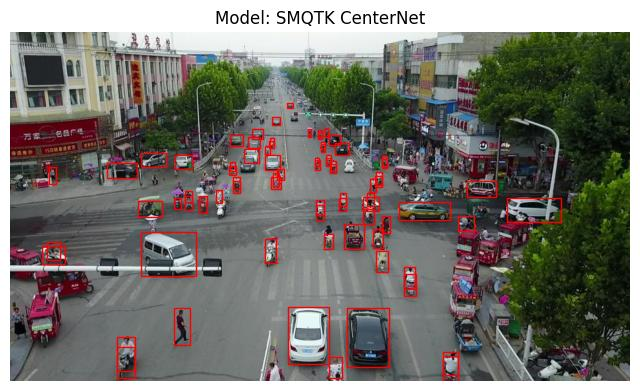

In [9]:
# Display initial images and detections
display(data_in, "Model: SMQTK CenterNet")

Lastly, for reproducability, we'll define a function that seeds the various random number generators

In [10]:
def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    imgaug.random.seed(seed)
    torch.manual_seed(seed)

## Albumentations <a name="albumentations"></a>

Throughout our exploration of these various augmentation tools, we will define a relatively simple pipeline, aiming to create similar pipelines across all tools. Additionally, we'll make sure each pipeline has some built-in randomness to determine the state of reproducability of each tool. 

[Albumentations](https://github.com/albumentations-team/albumentations) is able to simultaneously transform multiple targets, so in addition to transforming our image we can easily transform our [bounding boxes](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), with support for multiple bounding box formats.

Some discussion of Albumentations reproducability can be found [here](https://albumentations.ai/docs/examples/serialization/).

It's also possible to integrate Albumentations with [PyTorch Transforms](https://albumentations.ai/docs/examples/pytorch_classification/) or [Tensorflow](https://albumentations.ai/docs/examples/tensorflow-example/).

Albumentations works with NumPy arrays.

In [11]:
def alb_augmentation(data: pr.SupportsObjectDetection) -> pr.SupportsObjectDetection:
    if TYPE_CHECKING:
        assert(isinstance(data, TypedDict))
    image = data["image"]
    objects = data["objects"]
    if TYPE_CHECKING:
        assert(isinstance(objects, TypedDict))
    bboxes = objects["boxes"]
    labels = objects["labels"]       
    
    augmentation_pipeline = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.8, contrast_limit=0.4)
    ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']))  

    out = augmentation_pipeline(
        image=image, 
        bboxes=bboxes, 
        class_labels=labels
    )

    out_dict = dict(
        image=out["image"],
        objects=dict(
            boxes=out["bboxes"],
            labels=out["class_labels"]
        )
    )

    if TYPE_CHECKING:
        assert(isinstance(out_dict, pr.SupportsObjectDetection))

    return out_dict

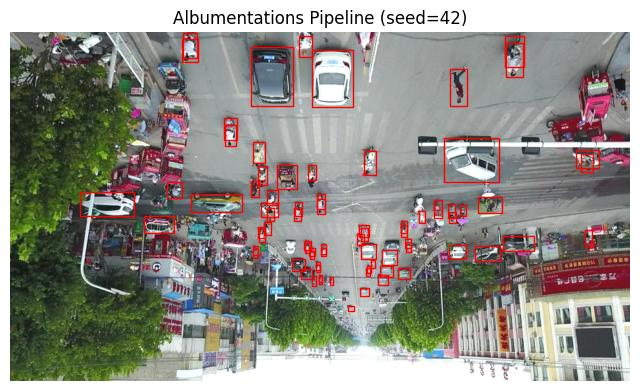

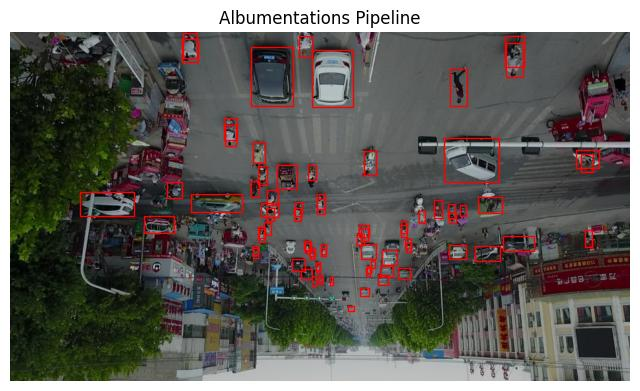

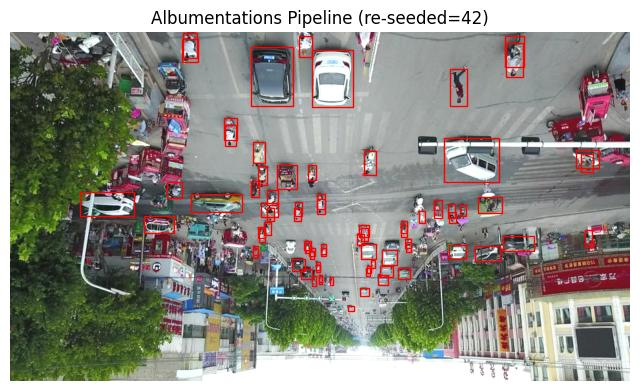

In [12]:
seed = 42

seed_all(seed)
alb_out1 = alb_augmentation(data_in)
display(alb_out1, f"Albumentations Pipeline (seed={seed})")

alb_out2 = alb_augmentation(data_in)
display(alb_out2, "Albumentations Pipeline")

seed_all(seed)
alb_out3 = alb_augmentation(data_in)
display(alb_out3, f"Albumentations Pipeline (re-seeded={seed})")

### ReplayCompose <a name="replaycompose"></a>

[ReplayCompose](https://albumentations.ai/docs/examples/replay/) is a tool from Albumentations that tracks augmentation parameters to reapply them to another image. Albumentations presents this as one way to apply the same parameters to multiple images, bounding boxes, etc. This usage might be a bit trickier to conform to the `Augmentation` protocol, but the tool might be useful for certain workflows.

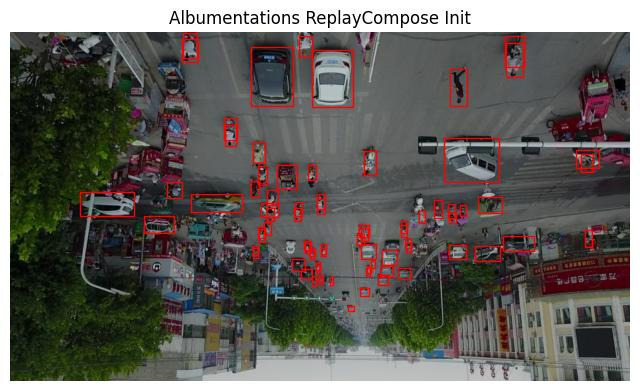

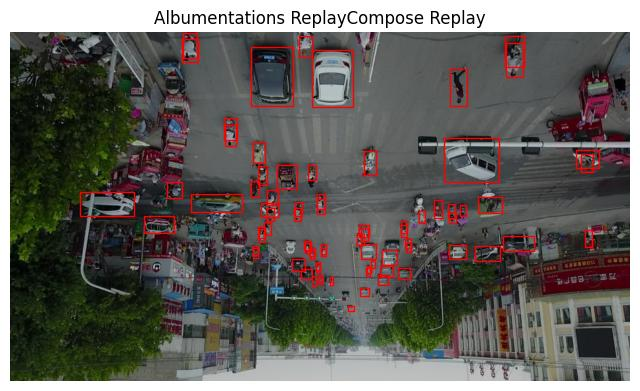

In [13]:
replay_pipeline = A.ReplayCompose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.8, contrast_limit=0.4)
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels'])) 

replay_out = replay_pipeline(
    image=data_in["image"], 
    bboxes=data_in["objects"]["boxes"], 
    class_labels=data_in["objects"]["labels"]
)
replay_out1 = dict(
    image=replay_out["image"],
    objects=dict(
        boxes=replay_out["bboxes"],
        labels=replay_out["class_labels"]
    )
)

tmp = A.ReplayCompose.replay(
    replay_out["replay"],
    image=data_in["image"], 
    bboxes=data_in["objects"]["boxes"], 
    class_labels=data_in["objects"]["labels"]
)
replay_out2 = dict(
    image=tmp["image"],
    objects=dict(
        boxes=tmp["bboxes"],
        labels=tmp["class_labels"]
    )
)

if TYPE_CHECKING:
    assert(isinstance(replay_out1, pr.SupportsObjectDetection))
    assert(isinstance(replay_out2, pr.SupportsObjectDetection))
display(replay_out1, "Albumentations ReplayCompose Init")
display(replay_out2, "Albumentations ReplayCompose Replay")

# Images should be the same
replay_image1 = replay_out1["image"]
replay_image2 = replay_out2["image"]
if TYPE_CHECKING:
    assert(isinstance(replay_image1, np.ndarray))
    assert(isinstance(replay_image2, np.ndarray))
assert(np.allclose(replay_image1, replay_image2))

## AugLy <a name="augly"></a>

Like Albumentations, [AugLy](https://github.com/facebookresearch/AugLy) can integrate with [PyTorch transformations](https://augly.readthedocs.io/en/latest/README_image.html#class-based).

AugLy can also preserve [bounding box information](https://augly.readthedocs.io/en/latest/README_image.html#augmenting-structured-data) (multiple bbox formats supported).

AugLy expects a PIL image as input but provides `aug_np_wrapper` which converts the numpy array to a PIL image and then calls the augmentation.

The optional `metadata` argument seems to provide enough information that it would be possible to re-construct the applied augmentation, but it's not necessarily straightforward to reapply that same augmentation.

In [14]:
def augly_augmentation(data: pr.SupportsObjectDetection) -> pr.SupportsObjectDetection:
    if TYPE_CHECKING:
        assert(isinstance(data, TypedDict))
    image = data["image"]
    objects = data["objects"]
    if TYPE_CHECKING:
        assert(isinstance(objects, TypedDict))
    bboxes = objects["boxes"]
    labels = objects["labels"]  
    
    augmentation_pipeline = imaugs.Compose([
        imaugs.HFlip(),
        imaugs.VFlip(),
        imaugs.RandomBrightness()
    ]) 

    meta = []
    if TYPE_CHECKING:
        assert(isinstance(image, np.ndarray))
    out = aug_np_wrapper(
        image, 
        augmentation_pipeline,  # type: ignore
        bboxes=bboxes,
        bbox_format="pascal_voc",
        metadata=meta,
    )

    out_dict = dict(
        image=out,
        objects=dict(
            boxes=meta[-1]["dst_bboxes"],
            labels=labels
        )
    )

    if TYPE_CHECKING:
        assert(isinstance(out_dict, pr.SupportsObjectDetection))

    return out_dict

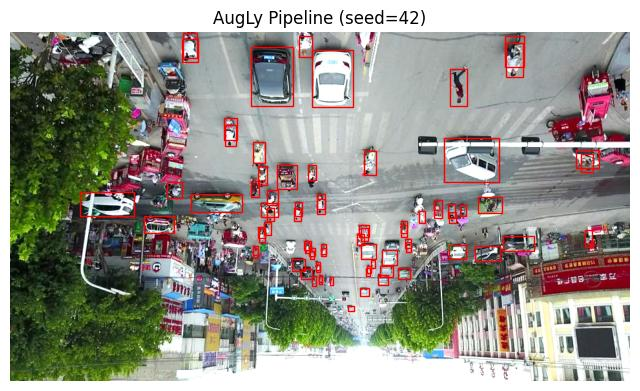

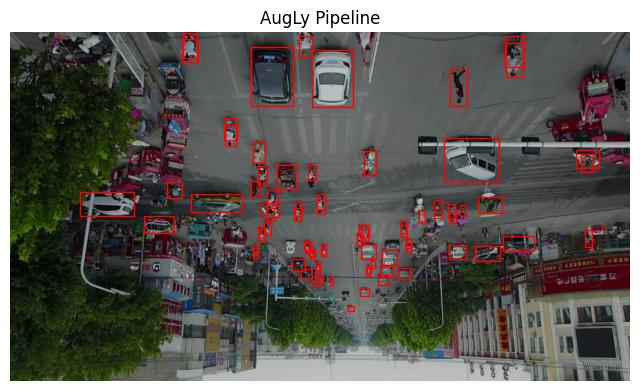

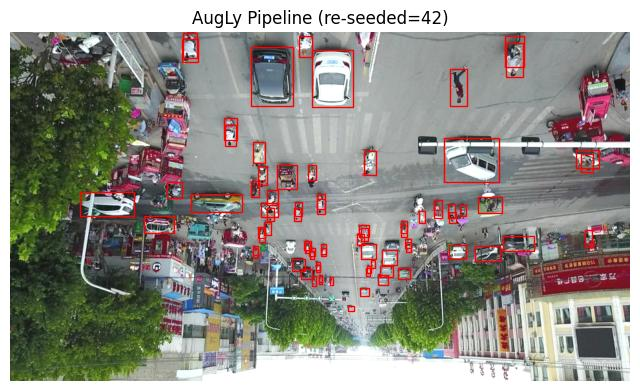

In [15]:
seed = 42

seed_all(seed)
imaug_out1 = augly_augmentation(data_in)
display(imaug_out1, f"AugLy Pipeline (seed={seed})")

imaug_out2 = augly_augmentation(data_in)
display(alb_out2, "AugLy Pipeline")

seed_all(seed)
imaug_out3 = augly_augmentation(data_in)
display(alb_out3, f"AugLy Pipeline (re-seeded={seed})")

## imgaug <a name="imgaug"></a>

Note: at least some of imgaug transforms seem to be available via [Albumentations](https://albumentations.ai/docs/api_reference/imgaug/transforms/)

While [imgaug](https://github.com/aleju/imgaug) is able to support transforming related data such as bounding boxes, bounding boxes are restricted to one format.

imgaug is able to support computing (CPU) batches of augmentations including on [multiple cores](https://nbviewer.org/github/aleju/imgaug-doc/blob/master/notebooks/A03%20-%20Multicore%20Augmentation.ipynb).

The documentation contains a section discussing the use of [stochastic parameters](https://imgaug.readthedocs.io/en/latest/source/parameters.html) as a means to determinism.

NumPy is the supported data format.

In [16]:
def imgaug_augmentation(data: pr.SupportsObjectDetection) -> pr.SupportsObjectDetection:
    if TYPE_CHECKING:
        assert(isinstance(data, TypedDict))
    image = data["image"]
    objects = data["objects"]
    if TYPE_CHECKING:
        assert(isinstance(image, np.ndarray))
        assert(isinstance(objects, TypedDict))
    bboxes = objects["boxes"]
    labels = objects["labels"] 

    bbs = BoundingBoxesOnImage.from_xyxy_array(np.array(bboxes), shape=image.shape)
    
    augmentation_seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # type: ignore
        iaa.Flipud(0.5),  # type: ignore
        iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))
    ])  

    img_aug, bbs_aug = augmentation_seq( # type: ignore
        image=image, 
        bounding_boxes=bbs, 
    )

    bboxes_aug = bbs_aug.to_xyxy_array()

    out_dict = dict(
        image=img_aug,
        objects=dict(
            boxes=bboxes_aug,
            labels=labels
        )
    )

    if TYPE_CHECKING:
        assert(isinstance(out_dict, pr.SupportsObjectDetection))

    return out_dict

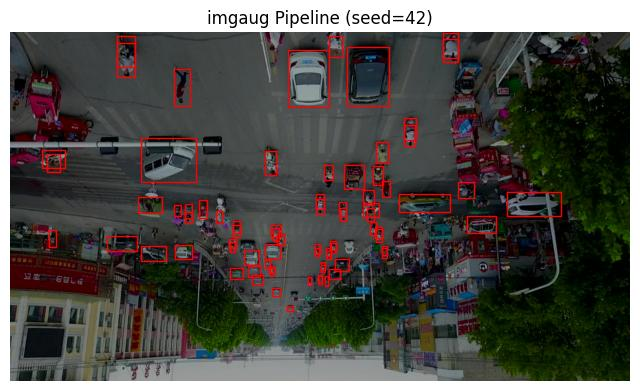

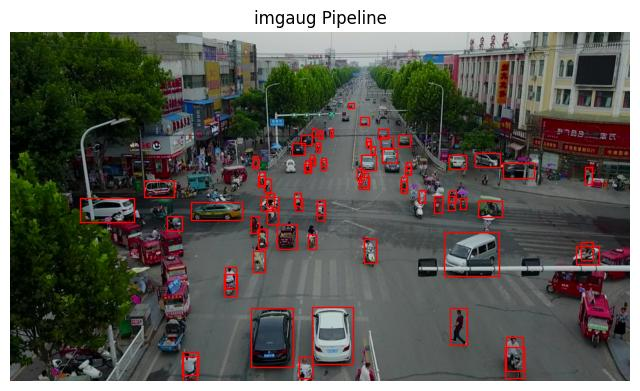

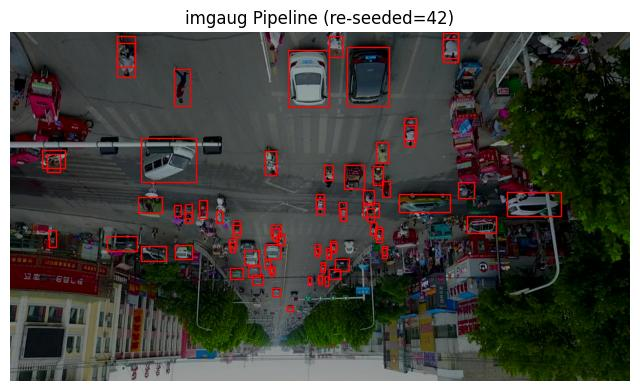

In [17]:
seed = 42

seed_all(seed)
imgaug_out1 = imgaug_augmentation(data_in)
display(imgaug_out1, f"imgaug Pipeline (seed={seed})")

imgaug_out2 = imgaug_augmentation(data_in)
display(imgaug_out2, "imgaug Pipeline")

seed_all(seed)
imgaug_out3 = imgaug_augmentation(data_in)
display(imgaug_out3, f"imgaug Pipeline (re-seeded={seed})")

## Kornia <a name="kornia"></a>

[Kornia](https://github.com/rdevon/kornia) is able to transform bounding boxes. As a way to support rotational transforms, Kornia strongly prefers all 4 corners of the bbox as input. A function to transform from `x_min, y_min, width, height` is provided. Documentation on transforming bounding boxes and other truth objects is sparse.

Kornia is able to do batched, on-GPU transformations.

PyTorch tensors are the built-in data format of Kornia. Note the channel first format of Kornia augmentations. Kornia docs also frequently reference BGR vs RGB.

In [18]:
def kornia_augmentation(data: pr.SupportsObjectDetection) -> pr.SupportsObjectDetection:
    def _to_kornia_bboxes(bboxes: np.ndarray) -> torch.Tensor:
        return bbox_generator(
            x_start=torch.Tensor(bboxes[:, 0]),
            y_start=torch.Tensor(bboxes[:, 1]),
            width=torch.Tensor(bboxes[:, 2]-bboxes[:, 0] + 1),
            height=torch.Tensor(bboxes[:, 3]-bboxes[:, 1] + 1)
        )

    def _from_kornia_bboxes(bboxes: torch.Tensor) -> np.ndarray:
        out_boxes = np.empty((0, 4))
        for box in bboxes.numpy():
            out_boxes = np.vstack((
                out_boxes,
                np.append(
                    np.min(box, axis=0), 
                    np.max(box, axis=0)
                )
            ))
        return out_boxes

    if TYPE_CHECKING:
        assert(isinstance(data, TypedDict))
    objects = data["objects"]
    if TYPE_CHECKING:
        assert(isinstance(objects, TypedDict))
    im = np.array(data["image"])
    im = np.moveaxis(im, 2, 0)
    image = torch.as_tensor((im-np.min(im))/(np.max(im)-np.min(im)), dtype=torch.float32)
    bboxes = _to_kornia_bboxes(np.array(objects["boxes"]))
    labels = objects["labels"]
    
    augmentation_seq = AugmentationSequential(
        K.augmentation.RandomHorizontalFlip(p=0.5),
        K.augmentation.RandomVerticalFlip(p=0.5),
        K.augmentation.RandomBrightness(brightness=(0.8, 1.2), clip_output=True, p=0.8),
        data_keys = ["input", "bbox"],
    ) 

    out = augmentation_seq(
        image, 
        bboxes
    )

    img_out = np.moveaxis((out[0][0].numpy() * 255).astype(int), 0, 2)
    bboxes_out = _from_kornia_bboxes(out[1])

    out_dict = dict(
        image=img_out,
        objects=dict(
            boxes=bboxes_out,
            labels=labels
        )
    )

    if TYPE_CHECKING:
        assert(isinstance(out_dict, pr.SupportsObjectDetection))

    return out_dict

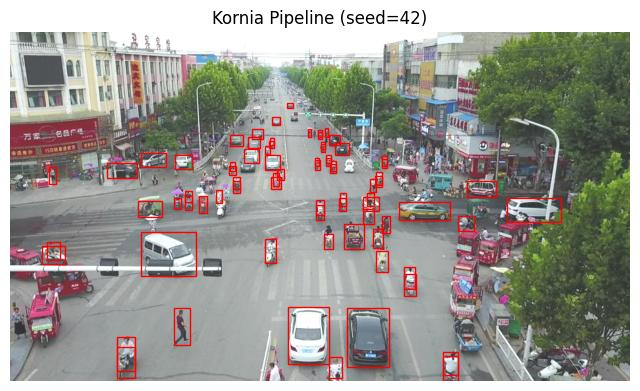

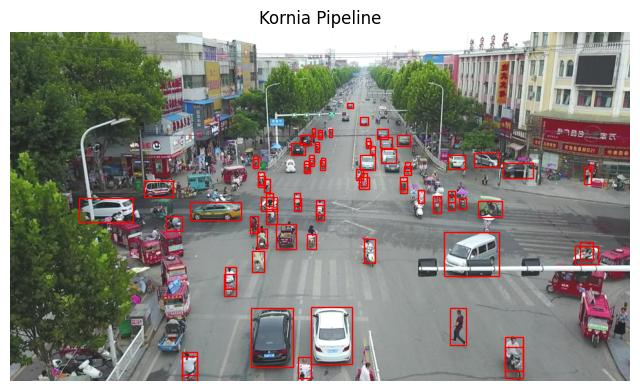

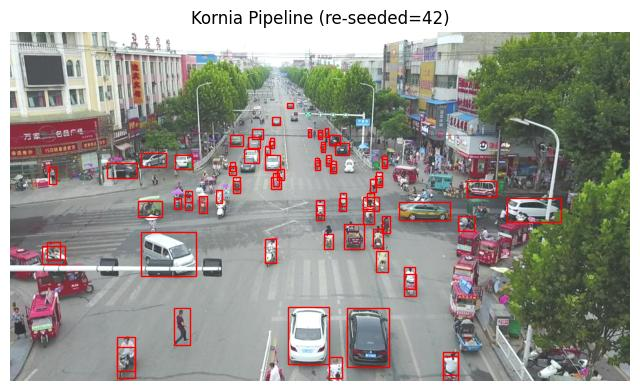

In [19]:
seed = 42

seed_all(seed)
kornia_out1 = kornia_augmentation(data_in)
display(kornia_out1, f"Kornia Pipeline (seed={seed})")

kornia_out2 = kornia_augmentation(data_in)
display(kornia_out2, "Kornia Pipeline")

seed_all(seed)
kornia_out3 = kornia_augmentation(data_in)
display(kornia_out3, f"Kornia Pipeline (re-seeded={seed})")

## Torchvision Transforms v2 <a name="torchvision-transforms"></a>

Torchvision Transforms v1 does not have the capability to transform truth objects along with the image, but the v2 of the API aims to correct this issue. v2 is a drop-in replacement for v1. Note that the v2 of this API is still in beta.

On-GPU and batched transforms are possible with torchvision. 

Many of torchvisions transforms expect PIL images as input.

In [20]:
def torchvision_augmentation(data: pr.SupportsObjectDetection) -> pr.SupportsObjectDetection:
    if TYPE_CHECKING:
        assert(isinstance(data, TypedDict))
    image = data["image"]
    objects = data["objects"]
    if TYPE_CHECKING:
        assert(isinstance(image, np.ndarray))
        assert(isinstance(objects, TypedDict))
    bboxes = objects["boxes"]
    labels = objects["labels"]
    h, w, _ = np.shape(image)

    bbs = tv_tensors.BoundingBoxes(np.array(bboxes), format="XYXY", canvas_size=(h, w))  # type: ignore
    
    augmentation_pipeline = T.Compose([
        T.ToPILImage(), 
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.ColorJitter(brightness=(0.5,1.5), contrast=(1), saturation=(0.5,1.5), hue=(-0.1,0.1))
    ])  

    img_aug, bbs_aug, labels_aug = augmentation_pipeline(
        image, 
        bbs,
        labels
    )

    out_dict = dict(
        image=np.array(img_aug),
        objects=dict(
            boxes=bbs_aug,
            labels=labels_aug
        )
    )

    if TYPE_CHECKING:
        assert(isinstance(out_dict, pr.SupportsObjectDetection))

    return out_dict

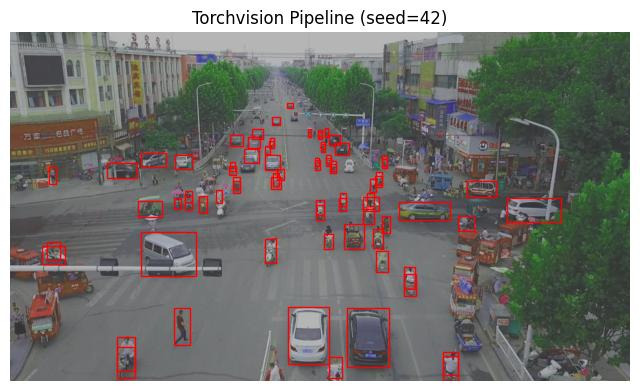

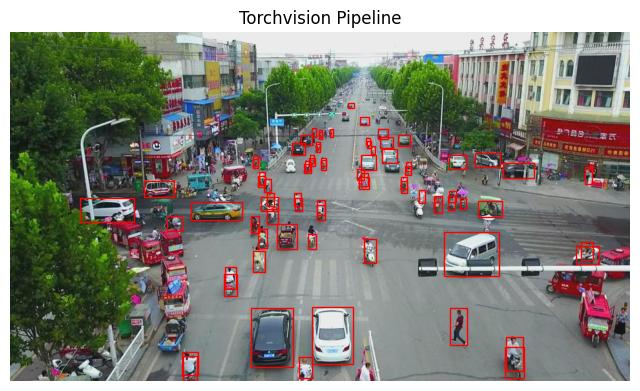

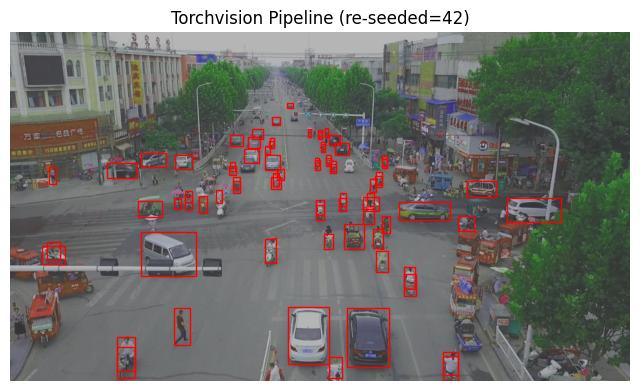

In [21]:
seed = 42

seed_all(seed)
torchvsion_out1 = torchvision_augmentation(data_in)
display(torchvsion_out1, f"Torchvision Pipeline (seed={seed})")

torchvsion_out2 = torchvision_augmentation(data_in)
display(torchvsion_out2, "Torchvision Pipeline")

seed_all(seed)
torchvsion_out3 = torchvision_augmentation(data_in)
display(torchvsion_out3, f"Torchvision Pipeline (re-seeded={seed})")

## NVIDIA Data Loading Library (DALI) <a name="dali"></a>

[DALI](https://developer.nvidia.com/dali) supports batched and on-GPU transformations. Additionally, DALI is able to transform truth objects, however the transforms for truth objects are required to be more explicit for truth objects; instead of getting the transformation "for free". 

DALI's API does not heavily present a compose-style option and instead is based on functional calls. This structure doesn't fit in as well with the JATIC `Augmentation` protocol, but it can still be made to work by creating a class-based Callable instead of a functor-based one.

Uniquely, DALI does not depend on the state of global RNGs. Instead, the user must provide a seed to the overall pipeline and/or to individual operations for reproducability.

In [22]:
class DaliAugmentation:
    def __init__(self, batch_size: int=1, num_threads: int=1, device_id: int=0, seed: int=-1):
        self._batch_size = batch_size
        self._num_threads = num_threads
        self._device_id = device_id
        self._data = self._InputIterator(self._batch_size)
        self.seed_pipeline(seed)

    def __call__(self, data: pr.SupportsObjectDetection) -> pr.SupportsObjectDetection:
        self._data.set_data(data)
        
        pipe_images, pipe_bboxes, pipe_labels = self._pipeline.run()

        images_out = pipe_images.as_array()
        h, w, _ = np.shape(images_out[0])
        images_out = np.squeeze(images_out, axis=0)
        boxes_out = pipe_bboxes.as_array()
        for idx, boxes in enumerate(boxes_out):
            boxes_out[idx] = DaliAugmentation._from_normalized_xywh(boxes, h, w)
        boxes_out = np.squeeze(boxes_out, axis=0)
        labels_out = np.squeeze(pipe_labels.as_array(), axis=0)
    
        out_dict = dict(
            image=images_out,
            objects=dict(
                boxes=boxes_out,
                labels=labels_out
        ))
        
        if TYPE_CHECKING:
            assert(isinstance(out_dict, pr.SupportsObjectDetection))
        
        return out_dict

    def seed_pipeline(self, seed: int):
        self._seed = seed
        self._pipeline = self._cpu_pipeline(  # type: ignore
            batch_size=self._batch_size, num_threads=self._num_threads,   # type: ignore
            device_id=self._device_id, seed=self._seed  # type: ignore
        ) 
        self._pipeline.build()  

    # Actual pipeline definition where augmentations are defined
    @pipeline_def()
    def _cpu_pipeline(self):
        images, boxes, labels = fn.external_source(source=self._data, num_outputs=3)

        vflip_prob = fnrand.coin_flip(probability=0.5)
        hflip_prob = fnrand.coin_flip(probability=0.5)
        converted = fnflip(
            images, 
            vertical=vflip_prob, 
            horizontal=hflip_prob
        )
        converted_boxes = fnbb_flip(
            boxes, 
            vertical=vflip_prob, 
            horizontal=hflip_prob
        )

        converted = fnbrightness_contrast(
            converted, 
           brightness=fnrand.uniform(range=[0.25, 2.]),
           contrast=fnrand.uniform(range=[0.1, 1.]),
           contrast_center=100
        )
        
        return converted, converted_boxes, labels

    # Custom iterator for on the fly data loading
    class _InputIterator:
        def __init__(self, batch_size, data: Optional[pr.SupportsObjectDetection]=None):
            self.batch_size = batch_size
            if data is not None:
                self.set_data(data)
            else:
                self.images = []
                self.boxes = []
                self.labels = []

        def set_data(self, data: pr.SupportsObjectDetection):
            if TYPE_CHECKING:
                assert(isinstance(data, TypedDict))
            objects = data["objects"]
            if TYPE_CHECKING:
                assert(isinstance(objects, TypedDict))
            if isinstance(data["image"], Sequence):
                self.images = data["image"]
                self.boxes = objects["boxes"]
                self.labels = objects["labels"]
            else:
                self.images = [data["image"]]
                self.boxes = [objects["boxes"]]
                self.labels = [objects["labels"]]
                
            if TYPE_CHECKING:
                assert(isinstance(self.images, Sequence))
            self.i = 0
            self.n = len(self.images)

        def __iter__(self):
            self.i = 0
            if TYPE_CHECKING:
                assert(isinstance(self.images, Sequence))
            self.n = len(self.images)
            return self

        def __next__(self):
            if TYPE_CHECKING:
                assert(isinstance(self.images, Sequence))
                assert(isinstance(self.boxes, Sequence))
                assert(isinstance(self.labels, Sequence))
            imgs, boxes, labels = [], [], []
            for _ in range(self.batch_size):
                imgs.append(self.images[self.i])
                h, w, _ = imgs[-1].shape
                boxes.append(DaliAugmentation._to_normalized_xywh(np.array(self.boxes[self.i]), h, w).astype(np.float32))
                labels.append(np.array(self.labels[self.i]))
                self.i = (self.i + 1) % self.n
            return (imgs, boxes, labels)

    @staticmethod
    def _to_normalized_xywh(bboxes: np.ndarray, h: int, w: int) -> np.ndarray:
        out_boxes = np.empty(np.shape(bboxes))
        out_boxes[:, 0] = bboxes[:, 0] / w
        out_boxes[:, 1] = bboxes[:, 1] / h
        out_boxes[:, 2] = (bboxes[:, 2] - bboxes[:, 0]) / w
        out_boxes[:, 3] = (bboxes[:, 3] - bboxes[:, 1]) / h
    
        return out_boxes

    @staticmethod
    def _from_normalized_xywh(bboxes: np.ndarray, h: int, w: int) -> np.ndarray:
        out_boxes = np.empty(np.shape(bboxes))
        out_boxes[:, 0] = bboxes[:, 0] * w
        out_boxes[:, 1] = bboxes[:, 1] * h
        out_boxes[:, 2] = out_boxes[:, 0] + bboxes[:, 2] * w
        out_boxes[:, 3] = out_boxes[:, 1] + bboxes[:, 3] * h
    
        return out_boxes.astype(int)           

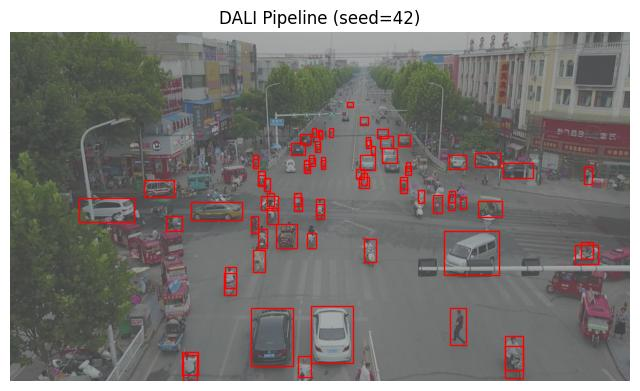

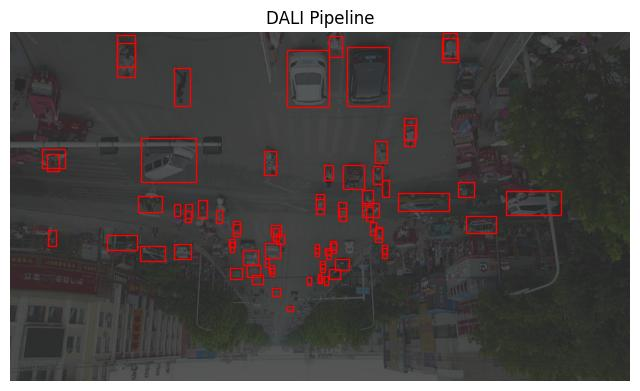

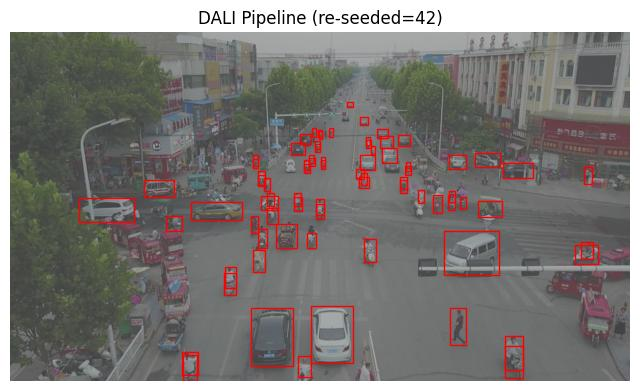

In [23]:
# While DALI doesn't have to run on the GPU, it requires NVIDIA Drivers and
# CUDA Toolkit to be installed
if torch.cuda.is_available():
    seed = 42
    dali_aug = DaliAugmentation(seed=seed)
    
    dali_out1 = dali_aug(data_in)
    display(dali_out1, f"DALI Pipeline (seed={seed})")
    
    dali_out2 = dali_aug(data_in)
    display(dali_out2, "DALI Pipeline")
    
    dali_aug.seed_pipeline(seed)
    dali_out3 = dali_aug(data_in)
    display(dali_out3, f"DALI Pipeline (re-seeded={seed})")